# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Загрузим и подготовим данные

In [341]:
import time
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, mean_absolute_error as mae
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline



from tqdm.notebook import tqdm
import nltk
from nltk.stem import WordNetLemmatizer 

<b>Откроем файл и изучим его<b/>

In [305]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

In [306]:
display(df.info())
display(df.head(15))
display('Количество явных дубликтов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


'Количество явных дубликтов:'

0

Как видно из данных в text присутствют переносы текста \n, а также знаки препинания/восклицетельные знаки + многие значения в разных регистрах и т.п., это всё может значительно усложнить обучние модели и понизить итоговое значение f1. 
Короче говоря нам необходимо предобработать эти данные(очистить). Для очистки будем использовать регулярные выражения из урока про векторизацию текстов.

In [307]:
def clear_text(text):
    text = text.lower()  
    clear_text  = re.sub(r"(?:\n|\r)", " ", text)
    clear_text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    return clear_text

In [308]:
df['clear_text'] = df['text'].apply(clear_text)
display(df.head(15))

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanationwhy the edits made under my usernam...
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,morei cant make any real suggestions on improv...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations from me as well use the tools ...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


На следующем шаге мы будем лемматизировать данные - приводить слова к их начальной форме

In [320]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return " ".join(x)

tqdm.pandas()
df['text_lemma'] = df['clear_text'].apply(lemmatize_text)

Посмотрим на распределение признака на датафрейме

In [322]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

<AxesSubplot:>

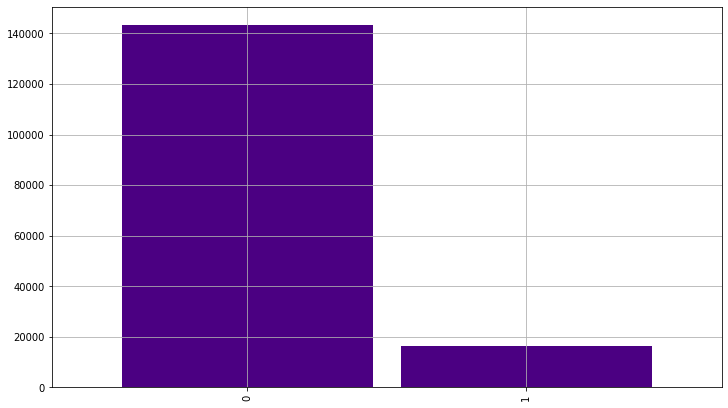

In [323]:
df['toxic'].value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='indigo',
    width=0.9,
    figsize=(12,7)
    )

Дисбаланс на лицо. Для борьбы с дисбалансом мы будем использовать увеличение(в части отрицательных) выборки, что мы изучали в спринте "Обучение с учителем"

<div class="alert alert-block alert-success">
<b>Успех:</b> Радует, что баланс классов был изучен.
</div>



## Обучение

Поделим выборки на тренировочную и тестовую.

In [324]:
features = df['text_lemma']
target = df['toxic']

In [325]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=.2, 
                                                                            random_state=42)

Уберём дисбаланс классов на всей выборке. Далее будем апсмемплить только тренировочную выборку


<b>Для начала посмотрим на распределение в обучающей выборке</b>


<AxesSubplot:>

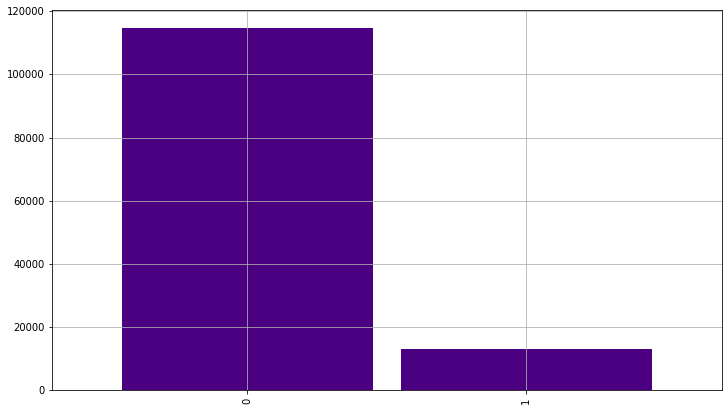

In [326]:
target_train.value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='indigo',
    width=0.9,
    figsize=(12,7)
    )

In [327]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    return shuffle(features_upsampled,target_upsampled, random_state=42)

In [328]:
features_train, target_train = upsample(features_train, target_train, 9)
#features_train, target_train = upsample(features, target, 9)
#repeat=9 тупо подобрал, самое равный баланс получился

<AxesSubplot:>

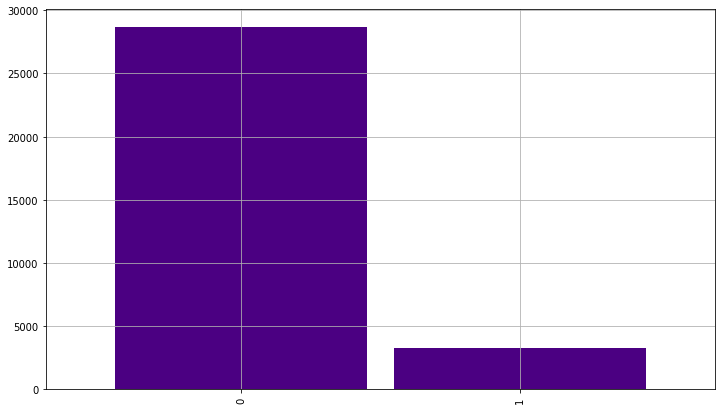

In [330]:
target_train.value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='indigo',
    width=0.9,
    figsize=(12,7)
    )

Векторизируем данные.


<b>Векторизатор засунем в Pipeline</b>


In [331]:
pipe = Pipeline([
    ('vectorize', TfidfVectorizer(ngram_range=(1, 1))),
    ('lg', LogisticRegression(max_iter=150, solver='liblinear', random_state=42))
                    ])

cv = KFold()

param_grid = {
    'vectorize__ngram_range': [(1, 1), (3, 1), (5, 2)],
    'lg__solver':['liblinear', 'lbfgs'],
    'lg__fit_intercept':[True, False],
}
# initialize
grid_pipeline_lr = GridSearchCV(pipe, param_grid,  cv = cv, scoring='f1')
# fit
grid_pipeline_lr.fit(features_train, target_train)
print(grid_pipeline_lr.best_score_)
print(grid_pipeline_lr.best_params_)


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/conda/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.

0.9585175873876421
{'lg__fit_intercept': True, 'lg__solver': 'liblinear', 'vectorize__ngram_range': (1, 1)}


In [332]:
lr_model = grid_pipeline_lr.best_estimator_
lr_model.fit(features_train, target_train)
lr_predictions = lr_model.predict(features_test)
print('LogisticRegression: ',f1_score(lr_predictions, target_test))

LogisticRegression:  0.7466379774072082


## Выводы

Мы проделали большое количество работы. Постараюсь кратко в данном разделе описать эти "подвиги"

- На начальном этапе мы ознакомились с данными. Посмотрели есть ли явные дубликаты, посмотрели на сами данные;
- Далее мы занялись обработкой данных. Сначала мы очистили данные с текстом от ненужного - переносы строк, ненужные пробелы, знаки;
- Затем мы лемматизировали данные;
- Выявив дисбаланс в данных мы апсэмплировали выборку для лучшей обучаемости модели;
- Так как перед нами стояла задача классификации, то мы выбрали логистическую регрессию. Но не стали сразу обучать её на данных;
- Сначала мы векторизировали данные, потом поделили выборки на обучающую и тестовую;
- Далее мы приступили к подбору гиперпараметров, подобрав которые мы смогли перейти к главному шагу этой работы - обучение модели. К слову подбор гиперпараметров был самом времязатратной операцией;
- Обучив модель и подставив гиперпараметры мы получили значение 0.94. Отличный результат.